# K-means clustering of fitbit heart rate data

In [1]:
import os
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [2]:
# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 16 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 18 # fontsize for figure titles
plt.rcParams['font.size'] = 14 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.4 # line width for plotting

In [3]:
# https://hackanons.com/2020/12/python-extract-data-from-json-file.html
def open_file(file):
#     with open("json_files/"+file) as f:
    with open(file) as f:
        json_data = json.load(f)
    return json_data

# print(json_data)

In [4]:
# First approximation to obtain heart rate data
# Note this does not consider the time axis in a consistent manner.

def extract_hr(json_data):
    heart_rate = np.zeros(len(json_data))

    for i in range(len(json_data)):
        values1 = [json_data[i][k] for k in json_data[i]]
        values2 = [values1[1][k] for k in values1[1]]
        heart_rate[i] = values2[0]
        
    return heart_rate

For the following, the data was divided in ~5s time bins, the heart rate average was obtained as well as the standard deviation. Then we ploted in 2D  and used K-means to cluster the data.

In [5]:
# Function that separates a string where the separator is

# https://stackoverflow.com/questions/4697006/python-split-string-by-list-of-separators
def split(txt, seps):
    default_sep = seps[0]

    # we skip seps[0] because that's the default separator
    for sep in seps[1:]:
        txt = txt.replace(sep, default_sep)
    return [i.strip() for i in txt.split(default_sep)]

In [6]:
# Extract different time formats arrays from json

def splitting_data(json_data):
    
    dict_keys1 = [k for k in json_data[0]]
    times = [json_data[k][dict_keys1[0]] for k in range(len(json_data))] # dateTime
    
    only_time = [split(times[k], ' ')[1] for k in range(len(times))]
    hms = [split(only_time[k], ":") for k in range(len(times))] #hour minute second

    # The index will represent the second of the day. Total of 86 400 seconds in one day

    # Converting the time to the number of second of the day
    seconds = [int(hms[k][0])*3600 + int(hms[k][1])*60 + int(hms[k][2]) for k in range(len(hms))]

    return times, only_time, hms, seconds

In [7]:
# First challenge, divide everything in 5min time bins, that is in 5*60 = 300 s time bins!
def data_5s(json_data):
    
    times, only_time, hms, seconds = splitting_data(json_data)
    vecs_sec = []
    vecs_indices = []
    
    for i in range(288): # Number of 5 min periods in 24 hours
        vec_sec = []
        vec_indices = []
        banner = False

        for index_i in range(np.argmin(seconds)): # len(indices)

            if i*300 <= seconds[index_i] and seconds[index_i] < (i+1)*300: # 5 min condition
                vec_sec.append(seconds[index_i])
                vec_indices.append(index_i)
                banner = True

            elif banner == True:
                vecs_sec.append(vec_sec)
                vecs_indices.append(vec_indices)
                break
                
    return vecs_sec, vecs_indices

In [8]:
# Divide everything in 1min time bins, that is in 60 s time bins!
def data_1s(json_data):
    
    times, only_time, hms, seconds = splitting_data(json_data)
    vecs_sec = []
    vecs_indices = []
    
    for i in range(1440): # Number of 1 min periods in 24 hours
        vec_sec = []
        vec_indices = []
        banner = False

        for index_i in range(np.argmin(seconds)): # len(indices)

            if i*60 <= seconds[index_i] and seconds[index_i] < (i+1)*60: #1 minute condition
                vec_sec.append(seconds[index_i])
                vec_indices.append(index_i)
                banner = True

            elif banner == True:
                vecs_sec.append(vec_sec)
                vecs_indices.append(vec_indices)
                break
                
    return vecs_sec, vecs_indices

In [9]:
###### Magic number, number of seconds in one day 
print(300*288)
print(24*3600)
print(86400/60)
print(288*5)

86400
86400
1440.0
1440


In [10]:
# Obtain the heart rate mean of these intervals as well as their standard deviation

def obtain_data(file_name):
    json_data = open_file(file_name)
    
    vecs_secs_5s, vecs_indices_5s = data_5s(json_data)
    vecs_secs_1s, vecs_indices_1s = data_1s(json_data)
    
    # For obtaining the time series
    times, only_time, hms, seconds = splitting_data(json_data) # Seconds has the correct x-entries for the heart rate time series
    heart_rate = np.zeros(len(json_data))

    for i in range(len(json_data)):
        values1 = [json_data[i][k] for k in json_data[i]] # Dictionary keys from the json files
        values2 = [values1[1][k] for k in values1[1]]
        heart_rate[i] = values2[0]
        
    # For obtaining the 5s data
    means_5s  = np.zeros(len(vecs_indices_5s))
    stdevs_5s = np.zeros(len(vecs_indices_5s))
    means_1s  = np.zeros(len(vecs_indices_1s))
    stdevs_1s = np.zeros(len(vecs_indices_1s))

    for i in range(len(vecs_indices_1s)):
        means_1s[i] = np.mean(heart_rate[vecs_indices_1s[i]])
        stdevs_1s[i] = np.std(heart_rate[vecs_indices_1s[i]])
        if (i+1)%5 == 0: #Each 5 seconds
            means_5s[round(i/5)-1] = np.mean(heart_rate[vecs_indices_5s[round(i/5)-1]]) # Start offset
            stdevs_5s[round(i/5)-1] = np.std(heart_rate[vecs_indices_5s[round(i/5)-1]])
        
    times = np.asarray(times)
    only_time = np.asarray(only_time)
    hms = np.asarray(hms)
    seconds = np.asarray(seconds)
    vecs_secs_5s = np.asarray(vecs_secs_5s)
    vecs_secs_1s = np.asarray(vecs_secs_1s)
    
    return  times, only_time, hms, seconds, vecs_secs_5s, heart_rate, means_5s, stdevs_5s, means_1s, stdevs_1s, vecs_secs_1s

In [11]:
# json_data = open_file("json_files/heart_rate-2021-08-31.json")
    
# vecs_secs_5s, vecs_indices_5s = data_5s(json_data)
# vecs_secs_1s, vecs_indices_1s = data_1s(json_data) # Smething is wrong5
# print(len(vecs_secs_5s))
# print(len(vecs_secs_1s))

In [12]:
# How to extract all the .json files from a folder

Folder = "json_files/" #Folder where the original files are
recordings_path = []

for TheFile in sorted(os.listdir(Folder)):
    TheFileName, TheFileExtension = os.path.splitext(TheFile) # breaks file name into pieces based on periods

    InputFilePath = Folder + TheFileName + TheFileExtension # Full path to file

    if (TheFileExtension==".json"): # Only interested in .json files
        recordings_path.append(InputFilePath)
        
# recordings_path  # They are NOW in sequential order

In [13]:
# Object
class Recording:
  def __init__(self, variables):
    # times, only_time, hms, seconds, heart_rate, means, stdevs
    self.times = variables[0]
    self.only_time = variables[1]
    self.hms = variables[2]
    self.seconds = variables[3]
    self.vecs_secs_5s = variables[4]
    self.heart_rate = variables[5]
    self.means_5s = variables[6]
    self.stdevs_5s = variables[7]
    self.means_1s = variables[8]
    self.stdevs_1s = variables[9]
    self.vecs_secs_1s = variables[10]

In [14]:
# json_data = open_file('json_files/heart_rate-2021-08-31.json')
    
# vecs_secs_5s, vecs_indices_5s = data_5s(json_data)
# vecs_secs_1s, vecs_indices_1s = data_1s(json_data)
    
# print(len(vecs_indices_5s))
# print(len(vecs_indices_1s))
# print(len(vecs_indices_1s)/len(vecs_indices_5s))

In [15]:
recordings = []

for i in range(0, 21):#len(recordings_path)):
    variables = obtain_data(recordings_path[i])
    recordings.append(Recording(variables))
    print("Finished recording ", i+1)

Finished recording  1
Finished recording  2
Finished recording  3
Finished recording  4
Finished recording  5
Finished recording  6
Finished recording  7
Finished recording  8
Finished recording  9
Finished recording  10
Finished recording  11
Finished recording  12
Finished recording  13
Finished recording  14
Finished recording  15
Finished recording  16
Finished recording  17
Finished recording  18
Finished recording  19
Finished recording  20
Finished recording  21


In [16]:
# when it reaches midnight, a new day starts, but the plot just starts back at 0 instead of continuing to hour 25.
# Good to know, we are handling data from two days. Not everything in this file corresponds to the day 8/31/2021

# When does midnight occur for the different recordings
for i in range(len(recordings)):
    print(i, " ", np.argmin(recordings[i].seconds))

0   7900
1   7375
2   8297
3   8304
4   7690
5   7555
6   7900
7   8328
8   8363
9   7285
10   8155
11   8096
12   8323
13   7217
14   7834
15   7939
16   8227
17   7833
18   8219
19   7887
20   7795


In [17]:
# Problem with recordings[25]. No means data :/
#Algo pasó con heart_rate-2021-09-25.json
# print(np.argmin(recordings[25].seconds))
# print(recordings_path[25])
# print(recordings[25].means)

# Generating a big array by concatenating multiple arrays.

In [18]:
# Shift the data from ONE day
def shift(recording):
    # all_seconds should be the same length as all_heart_rate
    recording_i = 0
    secs = recording.seconds

    # Correcting the number of seconds for midnight and restarting the number of seconds

    minimum_that_day = np.argmin(secs) #When midnight occurs
    shifted_seconds = secs

    # BEcause it actually corresponds to the next day 24*3600 = 86400
    shifted_seconds[minimum_that_day:] = recording.seconds[minimum_that_day:] + 86400

    return np.asarray(shifted_seconds)

In [19]:
# Now, we want to concatenate the previous recordings

n = 20
all_seconds = []
all_heart_rate = []
all_heart_rate = np.concatenate([recordings[i].heart_rate for i in range(n)]) #All data, not the 5 min bin ones

for recording_i in range(n): #Total number of recording for concatenation
    all_seconds.append(shift(recordings[recording_i])+86400*recording_i)
    
all_seconds = np.asarray(np.concatenate(all_seconds))

all_means_5s = np.concatenate([recordings[i].means_5s for i in range(n)]) # The 5 min bin ones
all_stdevs_5s = np.concatenate([recordings[i].stdevs_5s for i in range(n)]) #The 5 min bin ones
all_vecs_secs_5s = np.concatenate([recordings[i].vecs_secs_5s for i in range(n)]) # The 5 min bin ones

all_means_1s = np.concatenate([recordings[i].means_1s for i in range(n)]) # The 1 min bin ones
all_stdevs_1s = np.concatenate([recordings[i].stdevs_1s for i in range(n)]) #The 1 min bin ones
all_vecs_secs_1s = np.concatenate([recordings[i].vecs_secs_1s for i in range(n)])

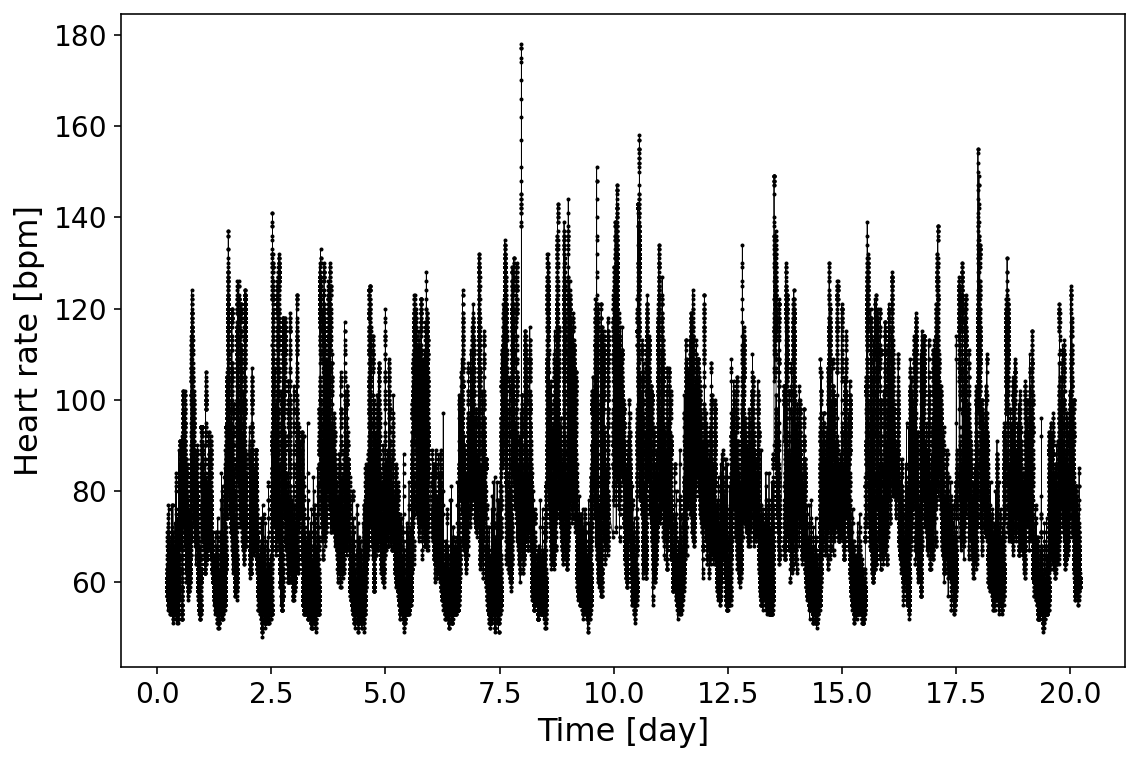

In [20]:
plt.figure(figsize= (9,6))

plt.plot(all_seconds/86400, all_heart_rate, c="k", marker=".", linewidth=0.4, markersize=2)
plt.xlabel("Time [day]")
plt.ylabel("Heart rate [bpm]")
plt.show()

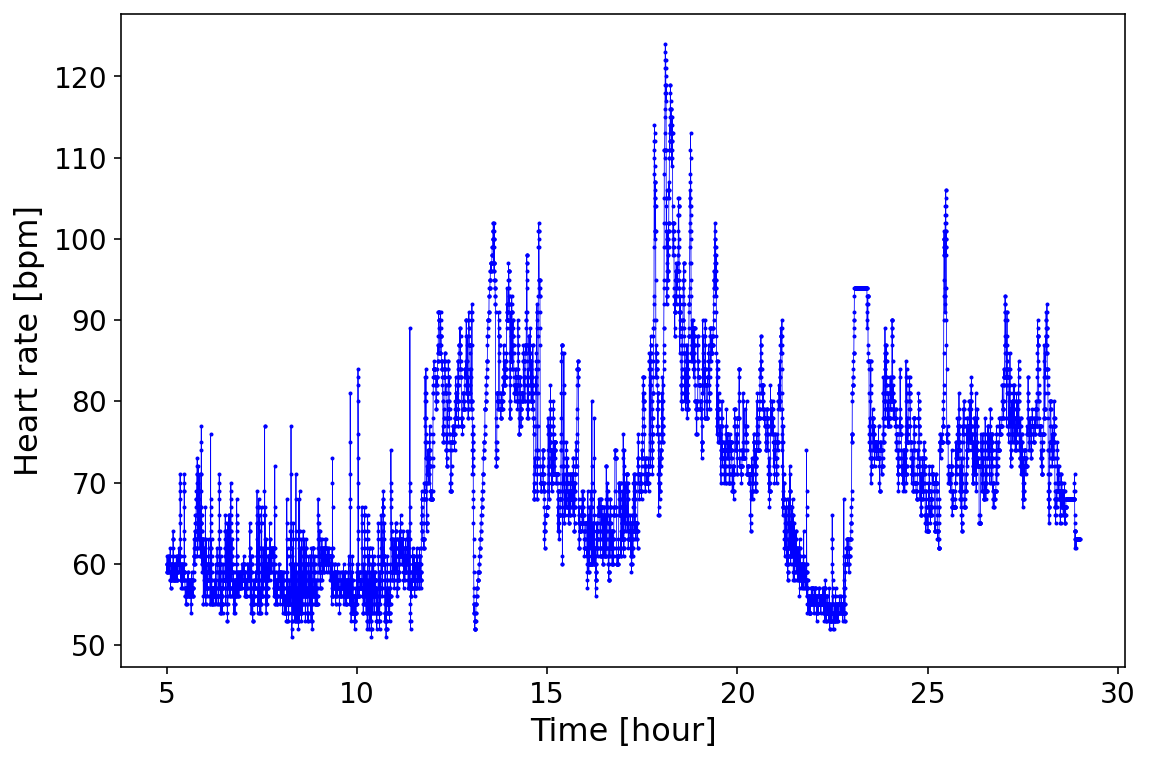

In [21]:
couleur = ["b", "k", "r"]
plt.figure(figsize= (9,6))

plt.plot((recordings[0].seconds)/3600, recordings[0].heart_rate, c="b", marker=".", linewidth=0.4, markersize=2)
plt.xlabel("Time [hour]")
plt.ylabel("Heart rate [bpm]")
plt.show()

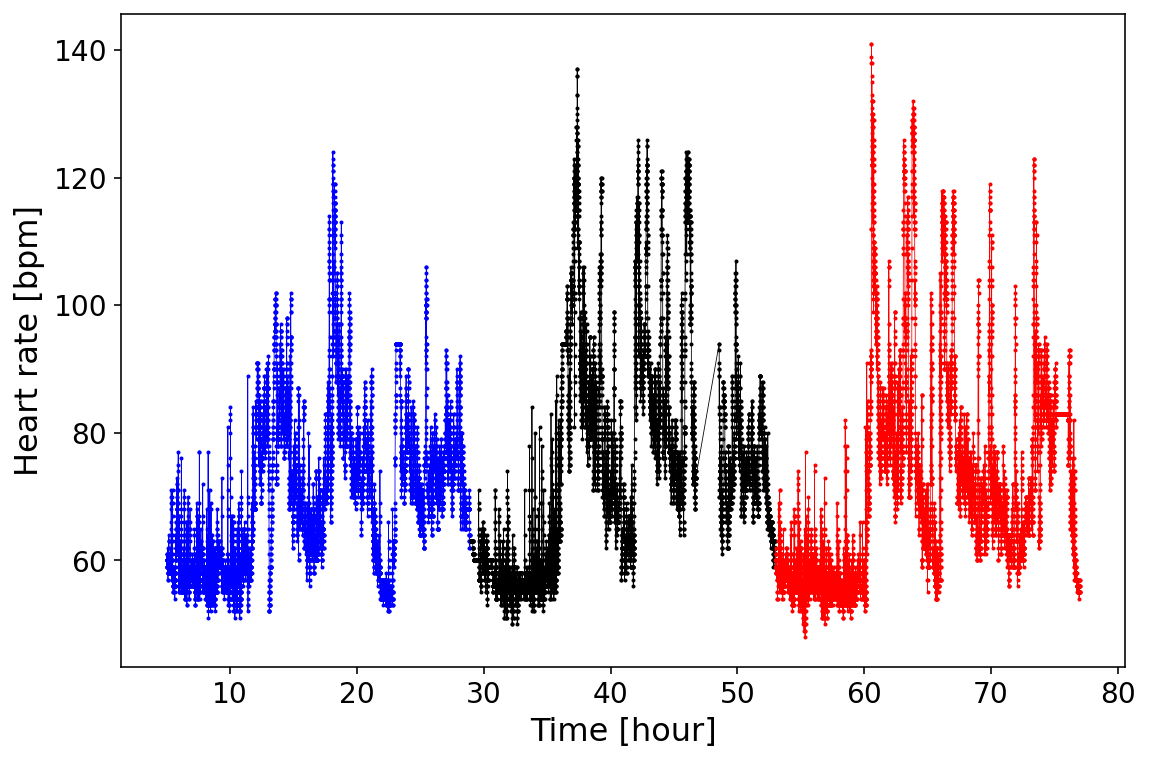

In [22]:
# Only 3 sequential recordings
couleur = ["b", "k", "r"]
plt.figure(figsize= (9,6))
for i in range(3):
    plt.plot((recordings[i].seconds+86400*i)/3600, recordings[i].heart_rate, c=couleur[i], marker=".", linewidth=0.4, markersize=2)
plt.xlabel("Time [hour]")
plt.ylabel("Heart rate [bpm]")
plt.show()

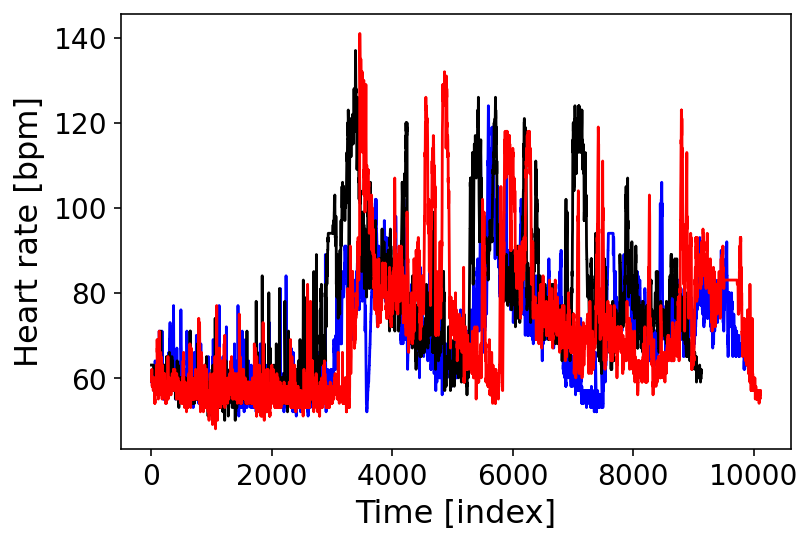

In [23]:
plt.plot(recordings[0].heart_rate, c="b")
plt.plot(recordings[1].heart_rate, c="k")
plt.plot(recordings[2].heart_rate, c="r")
plt.xlabel("Time [index]")
plt.ylabel("Heart rate [bpm]")
plt.show()

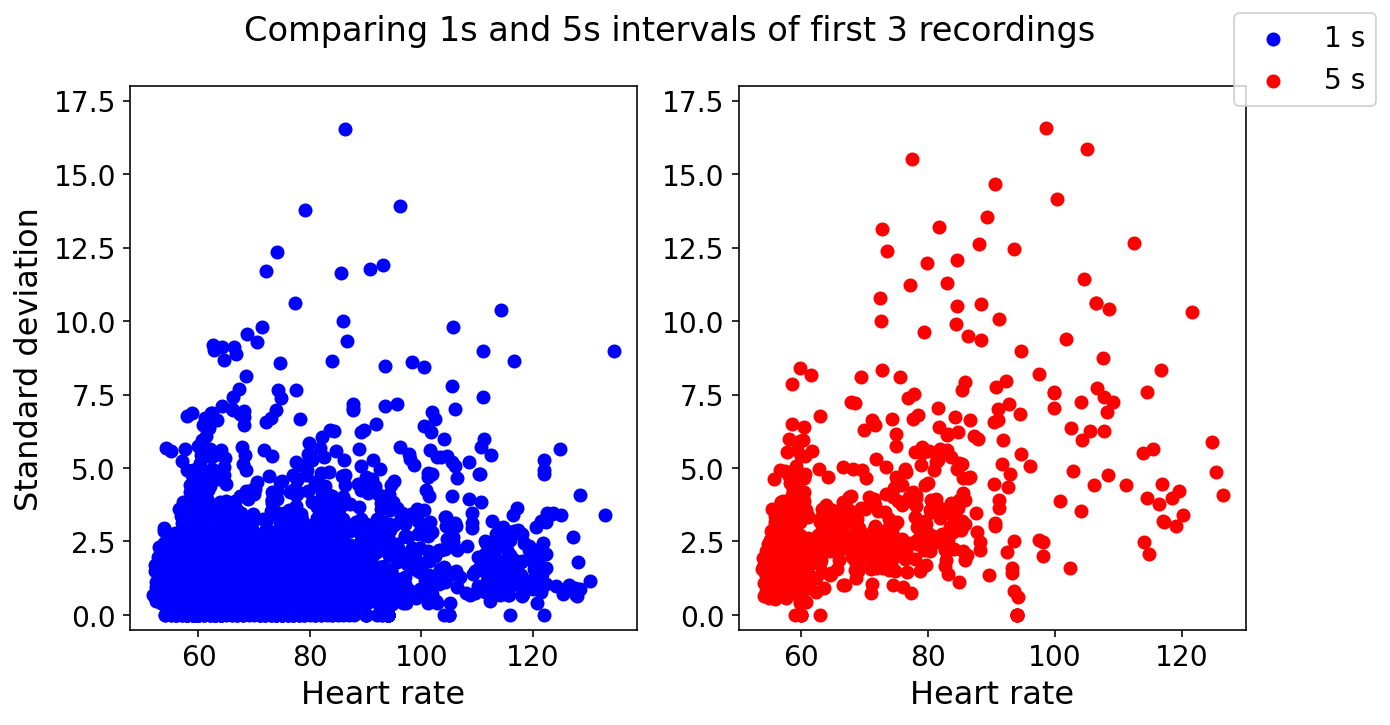

In [24]:
f, axs = plt.subplots(1,2,figsize=(10,5))
f.suptitle('Comparing 1s and 5s intervals of first 3 recordings') 

axs[0].scatter(recordings[0].means_1s, recordings[0].stdevs_1s, c = "b", label = '1 s')
axs[0].scatter(recordings[1].means_1s, recordings[1].stdevs_1s, c="b")
axs[0].scatter(recordings[2].means_1s, recordings[2].stdevs_1s, c="b")
axs[0].set_xlabel("Heart rate")
axs[0].set_ylabel("Standard deviation") # Heart rate variability
axs[0].set_ylim([-0.5, 18])

axs[1].scatter(recordings[0].means_5s, recordings[0].stdevs_5s, c = "r", label="5 s")
axs[1].scatter(recordings[1].means_5s, recordings[1].stdevs_5s, c="r")
axs[1].scatter(recordings[2].means_5s, recordings[2].stdevs_5s, c="r")
axs[1].set_xlabel("Heart rate")
axs[1].set_ylim([-0.5, 18])

f.legend()
plt.show()

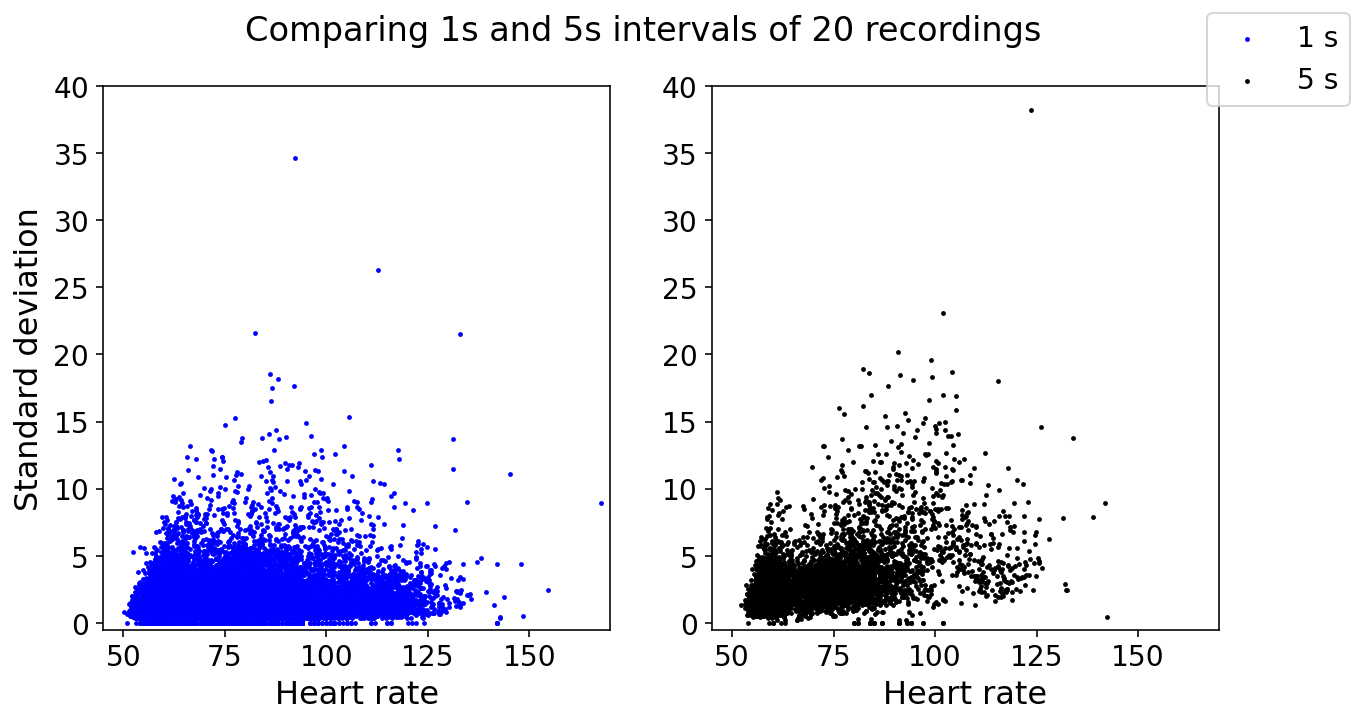

In [25]:
f, axs = plt.subplots(1,2,figsize=(10,5))
f.suptitle('Comparing 1s and 5s intervals of 20 recordings') 

axs[0].scatter(all_means_1s, all_stdevs_1s, s=2, c = "b", label = '1 s')
axs[0].set_xlabel("Heart rate")
axs[0].set_ylabel("Standard deviation") # Heart rate variability
axs[0].set_ylim([-0.5, 40])
axs[0].set_xlim([45, 170])

axs[1].scatter(all_means_5s, all_stdevs_5s, c = "k", s=2, label="5 s")
axs[1].set_xlabel("Heart rate")
axs[1].set_ylim([-0.5, 40])
axs[1].set_xlim([45, 170])


f.legend()
plt.show()

Generating the histogram of the previos data

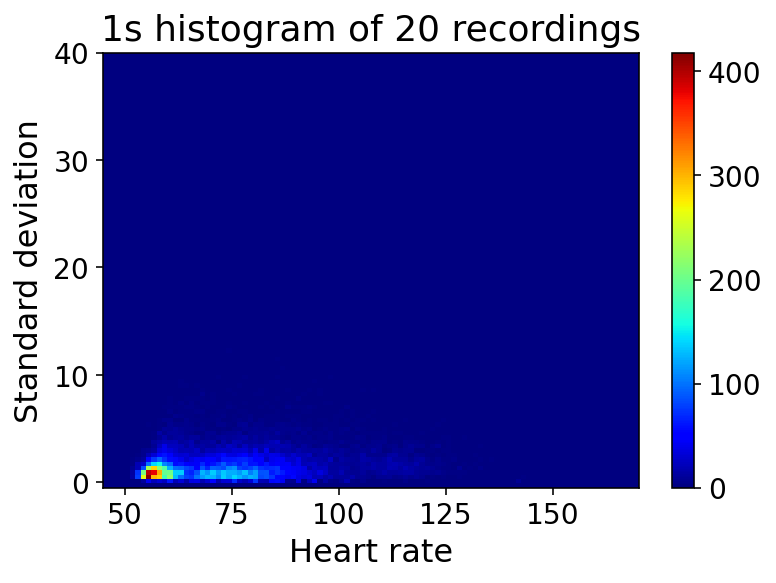

In [26]:
plt.hist2d(all_means_1s, all_stdevs_1s, bins=(100, 100), range=[[45, 170], [-0.5, 40]], density=False, weights=None, cmin=None, cmax=None, cmap="jet")
plt.title("1s histogram of 20 recordings")
plt.xlabel("Heart rate")
plt.ylabel("Standard deviation") # Heart rate variability

plt.colorbar()
plt.show()

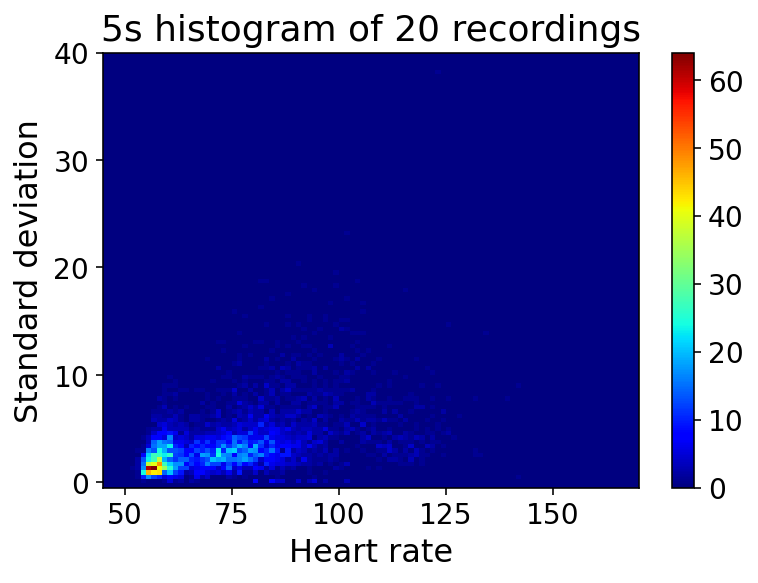

In [27]:
plt.hist2d(all_means_5s, all_stdevs_5s, bins=(100, 100), range=[[45, 170], [-0.5, 40]], density=False, weights=None, cmin=None, cmax=None, cmap="jet")
plt.title("5s histogram of 20 recordings")
plt.xlabel("Heart rate")
plt.ylabel("Standard deviation") # Heart rate variability
plt.colorbar()
plt.show()

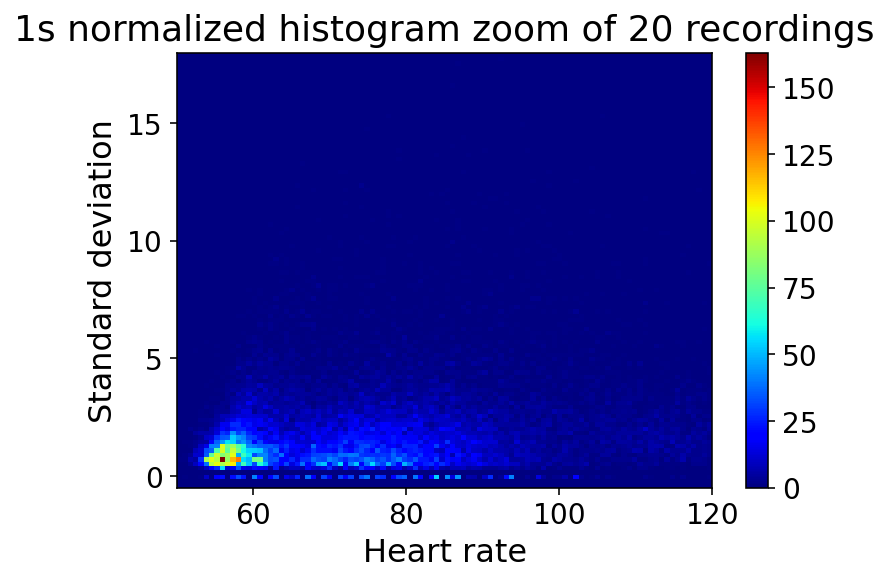

In [28]:
plt.hist2d(all_means_1s, all_stdevs_1s, bins=(100, 100), range=[[50, 120], [-0.5, 18]], density=False, weights=None, cmin=None, cmax=None, cmap="jet")
plt.xlabel("Heart rate")
plt.ylabel("Standard deviation") # Heart rate variability
plt.title("1s normalized histogram zoom of 20 recordings")
plt.colorbar()
plt.show()

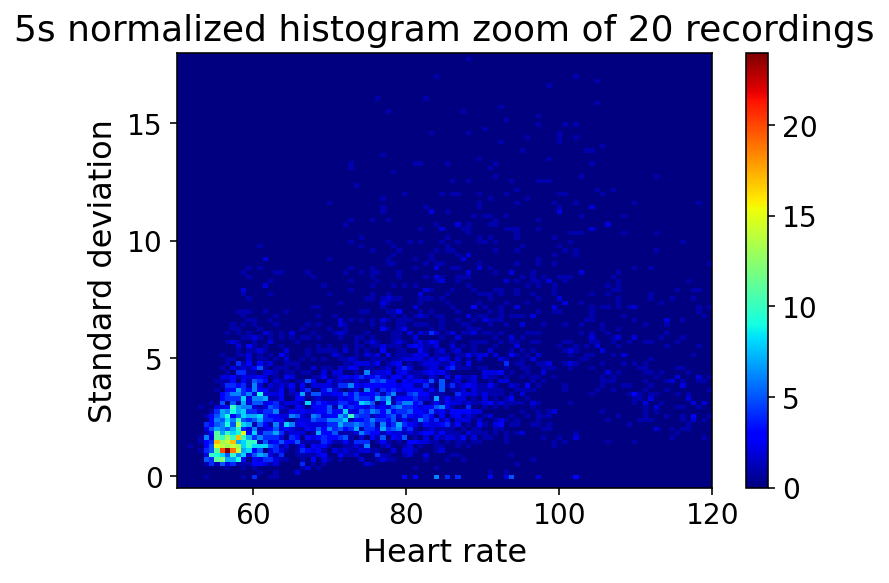

In [29]:
plt.hist2d(all_means_5s, all_stdevs_5s, bins=(100, 100), range=[[50, 120], [-0.5, 18]], density=False, weights=None, cmin=None, cmax=None, cmap="jet")
plt.title("5s normalized histogram zoom of 20 recordings")
plt.xlabel("Heart rate")
plt.ylabel("Standard deviation") # Heart rate variability
plt.colorbar()
plt.show()

Notice the two previous plots are comparable when multiplying the 5 s histogram by a factor of 5.

Now comes the interesting part, cluster these datapoints!

# Clustering with k-means

The code in HW4 is designed for minimizing the distance of a single array in 1D (voltage). In this case, you have 2D: heart rate and standard deviation. Modify the functions accordingly so to consider minimizing the distance to these 2 variables.

In [30]:
def iterative_cost_function(means, stdevs, mk_means, mk_stdevs, rnks): # Cost function for 1 cluster
    n = len(means)
    J = 0
    for i in range(n):
        if rnks[i]: 
            J += np.sum((means[i]-mk_means)**2 + (stdevs[i]-mk_stdevs)**2) #Sums the cost for the 2 dimensions
    return J


def all_clusters_cost_function(means, stdevs, mk_means, mk_stdevs, rnks): # Cost function for all clusters
    J = 0
    
    for cluster_i in range(len(mk_means)):
        J+= iterative_cost_function(means, stdevs, mk_means[cluster_i], mk_stdevs[cluster_i], rnks[cluster_i])
    return J

In [31]:
# Assigning a cluster based on distance between centroids and points:
def distances(means, stdevs, mk_means, mk_stdevs):
    number_of_clusters = len(mk_means) #3
    number_of_datapoints = len(means) # all the datapoints
    
    rnks_1 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_2 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_3 = np.zeros(number_of_datapoints, dtype = bool)
    
    for i in range(number_of_datapoints):
        distance = np.zeros(number_of_clusters)
        
        for cluster_i in range(number_of_clusters):
            # Considering the euclidian distance in 1 variable as well as in the other
            distance[cluster_i]= np.sum((means[i]-mk_means[cluster_i])**2 + (stdevs[i]-mk_stdevs[cluster_i])**2)
            
        minimum = np.argmin(distance) # For assigning a cluster to each datapoint
        
        if minimum ==0: # Belongs in cluster 1
            rnks_1[i] = 1
        elif minimum ==1: # Belongs in cluster 2
            rnks_2[i] = 1
        elif minimum ==2: # Belongs in cluster 3
            rnks_3[i] = 1
    return rnks_1, rnks_2, rnks_3

In [32]:
# Updating centroids
def updates_centroids(means, stdevs, rnks_1, rnks_2, rnks_3):
    c1_means = []
    c1_stdevs = []
    c2_means = []
    c2_stdevs = []
    c3_means = []
    c3_stdevs = []

    for i in range(len(means)):
        
        if rnks_1[i]:
            c1_means.append(means[i])
            c1_stdevs.append(stdevs[i])

        elif rnks_2[i]:
            c2_means.append(means[i])
            c2_stdevs.append(stdevs[i])

        elif rnks_3[i]:
            c3_means.append(means[i])
            c3_stdevs.append(stdevs[i])

    mks1_mean = np.mean(c1_means, 0)
    mks1_stdevs = np.mean(c1_stdevs, 0)
    
    mks2_mean = np.mean(c2_means, 0)
    mks2_stdevs = np.mean(c2_stdevs, 0)
    
    mks3_mean = np.mean(c3_means, 0)
    mks3_stdevs = np.mean(c3_stdevs, 0)
    
    return mks1_mean, mks1_stdevs, mks2_mean, mks2_stdevs, mks3_mean, mks3_stdevs

In [74]:
def one_iteration(means, stdevs, mks_mean_init, mks_stdevs_init):
    rnks_1, rnks_2, rnks_3 = distances(means, stdevs, mks_mean_init, mks_stdevs_init)
    mks1_mean, mks1_stdevs, mks2_mean, mks2_stdevs, mks3_mean, mks3_stdevs = updates_centroids(means, stdevs, rnks_1,
                                                                                               rnks_2, rnks_3)
    
    mks1_mean, mks1_stdevs, mks2_mean, mks2_stdevs, mks3_mean, mks3_stdevs = updates_centroids(means, stdevs, rnks_1,
                                                                                               rnks_2, rnks_3)
    
    mks_means = [mks1_mean, mks2_mean, mks3_mean]
    mks_stdevs = [mks1_stdevs, mks2_stdevs, mks3_stdevs]
    rnks = [rnks_1, rnks_2, rnks_3]
    
    J = all_clusters_cost_function(means, stdevs, mks_means, mks_stdevs, rnks)
    return J, rnks, mks_means, mks_stdevs

In [75]:
# Determines what data will run in the following cells, if the 1s one or the 5s.

# means = recordings[0].means
# stdevs = recordings[0].stdevs

means, stdevs, all_vecs_secs = all_means_1s, all_stdevs_1s, all_vecs_secs_1s
# means, stdevs, all_vecs_secs = all_means_5s, all_stdevs_5s, all_vecs_secs_5s

In [76]:
pool = len(means)
# Initializes with 3 random mean and stdevs values from the dataset
mks_mean_init = [means[round(pool*random.random())], means[round(pool*random.random())],
                 means[round(pool*random.random())]]
mks_stdevs_init = [stdevs[round(pool*random.random())], stdevs[round(pool*random.random())],
                   stdevs[round(pool*random.random())]]

J = []
i = 0
converging = False

J1, rnks_1, mk_means, mk_stdevs = one_iteration(means, stdevs, mks_mean_init, mks_stdevs_init) # First iteration
J.append(J1)

while converging == False:
# for i in range(10):
    J1, rnks, mk_means, mk_stdevs = one_iteration(means, stdevs, mk_means, mk_stdevs)
    J.append(J1)
    
    if np.abs(J[i-1]-J[i])< 0.0001*J[i]: # Finding the convergence value
        print("Converging value occurs in the ", i+1, "th iteration.")
        converging = True
    i +=1

Converging value occurs in the  18 th iteration.


In [77]:
J

[2141025.194059588,
 1655044.1950383754,
 1367697.5022342918,
 1170850.174435067,
 1053474.2277432163,
 978938.9626217925,
 936177.7792952323,
 913100.9026411718,
 901392.3754144716,
 894039.1949321056,
 890178.6813390811,
 888359.033164205,
 887648.5432384766,
 887389.333041912,
 887189.3697697476,
 886959.0058464453,
 886868.2548050988,
 886820.9778656499,
 886803.2363798328]

# IDEA
How many iterations did it take to converge? What convergence criterion are you using?

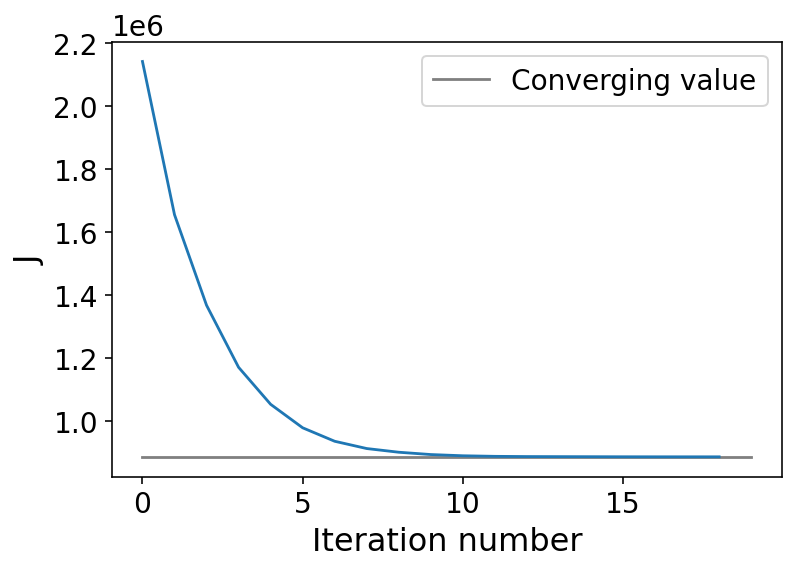

In [78]:
max_ind = len(J)
plt.plot([0,max_ind], [J[max_ind-1], J[max_ind-1]], label = "Converging value", color = "grey")
plt.plot(J)
plt.xlabel("Iteration number")
plt.ylabel("J")
plt.legend()
plt.show()

How to make the following cells run faster?
Generate vectors.

In [79]:
aux_means1 = []
aux_stdevs1 = []
aux_means2 = []
aux_stdevs2 = []
aux_means3 = []
aux_stdevs3 = []

for i in range(len(means)):

    if rnks[0][i]: #mk_means, mk_stdevs
        aux_means1.append(means[i]) #, stdevs[i], color="salmon", s=size)
        aux_stdevs1.append(stdevs[i]) #, stdevs[i], color="salmon", s=size)

    elif rnks[1][i]:
#         ax2.scatter(means[i], stdevs[i], color="deeppink", s=size)
        aux_means2.append(means[i]) #, stdevs[i], color="salmon", s=size)
        aux_stdevs2.append(stdevs[i]) #, stdevs[i], color="salmon", s=size)

    elif rnks[2][i]:
#         ax3.scatter(means[i], stdevs[i], color="dimgrey", s=size)
        aux_means3.append(means[i]) #, stdevs[i], color="salmon", s=size)
        aux_stdevs3.append(stdevs[i]) #, stdevs[i], color="salmon", s=size)

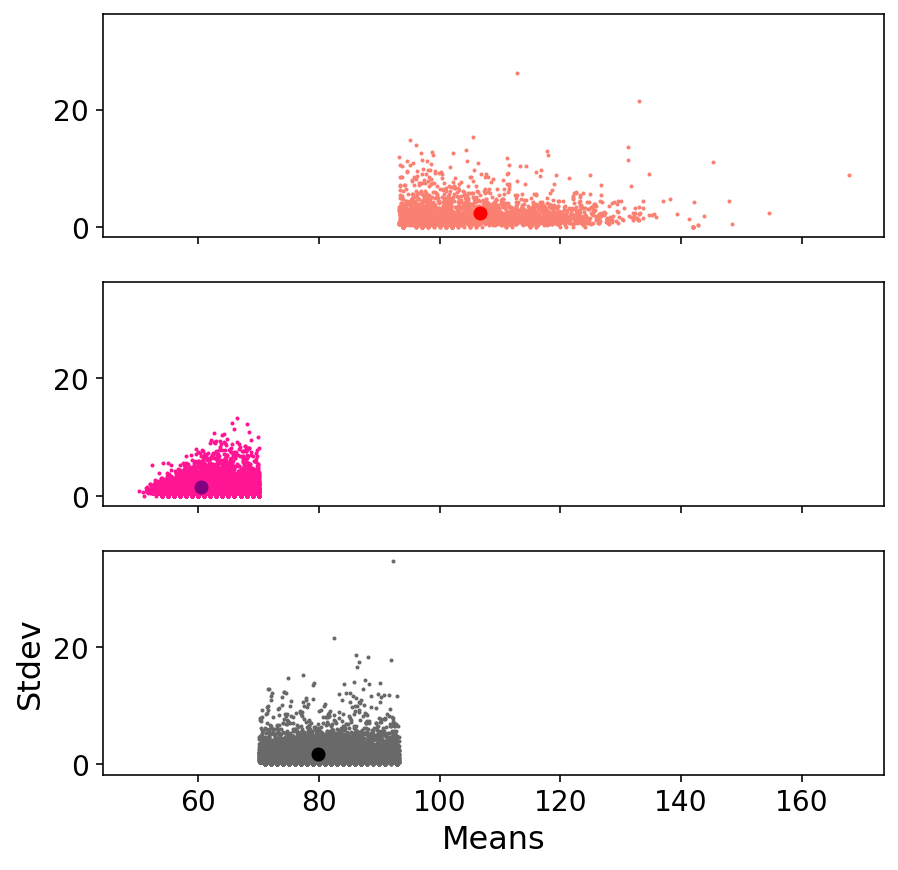

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(7,7))
size = 1
ax1.scatter(aux_means1, aux_stdevs1, color="salmon", s=size)
ax2.scatter(aux_means2, aux_stdevs2, color="deeppink", s=size)
ax3.scatter(aux_means3, aux_stdevs3, color="dimgrey", s=size)

ax1.scatter(mk_means[0], mk_stdevs[0], c="r")
ax2.scatter(mk_means[1], mk_stdevs[1], c="purple")
ax3.scatter(mk_means[2], mk_stdevs[2], c="k")
plt.xlabel('Means')
plt.ylabel("Stdev")
plt.show()

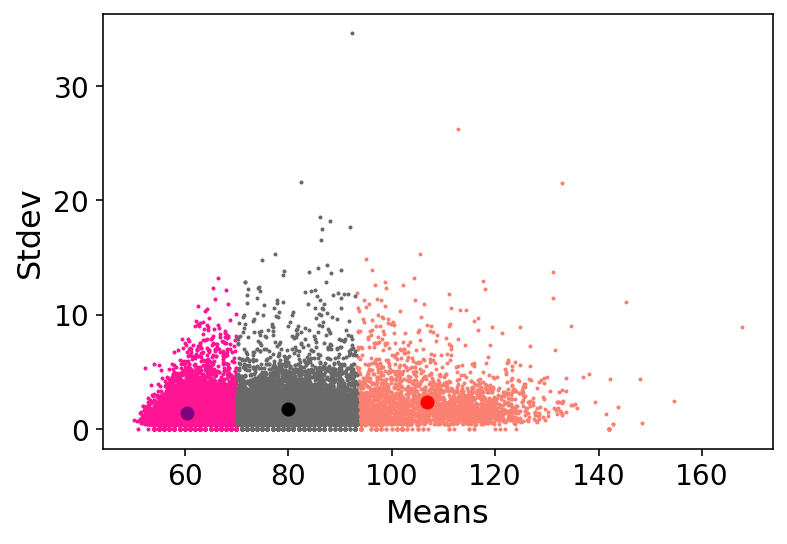

In [81]:
plt.scatter(aux_means1, aux_stdevs1, color="salmon", s=size)
plt.scatter(aux_means2, aux_stdevs2, color="deeppink", s=size)
plt.scatter(aux_means3, aux_stdevs3, color="dimgrey", s=size)

plt.scatter(mk_means[0], mk_stdevs[0], c="r")
plt.scatter(mk_means[1], mk_stdevs[1], c="purple")
plt.scatter(mk_means[2], mk_stdevs[2], c="k")
plt.xlabel('Means')
plt.ylabel("Stdev")
plt.show()

# What is the optimal number of clusters?

Now, we will use python's KMeans function.

In [82]:
ndata = [[means[i], stdevs[i]] for i in range(len(means))]

In [83]:
iterations = 15
J = np.zeros(iterations)

for K in range(2,iterations):
    kmeans = KMeans(n_clusters=K, random_state=0, algorithm="full").fit(ndata)
    J[K] = kmeans.inertia_ # This must be the cost function J

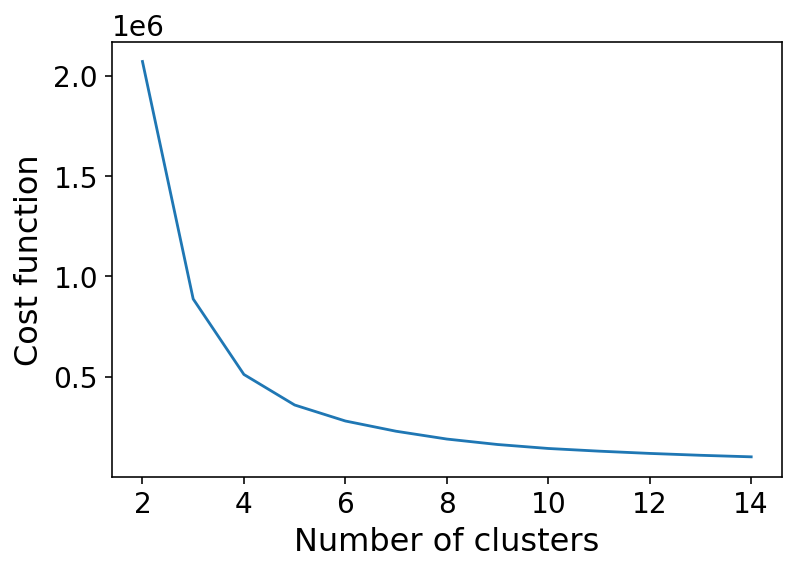

In [84]:
plt.plot([i+2 for i in range(13)], J[2:])
plt.xlabel("Number of clusters")
plt.ylabel("Cost function")
plt.show()

For finding the elbow of the previous curve, we can obtain the first derivative. When this value starts changes by a small amount, then we have found the elbow.

In [85]:
def firstDerivative(x):
    deriv = np.zeros(len(x)-1)
    for i in range(len(x)-1):
        deriv[i] = x[i+1] - x[i]
    return deriv

In [86]:
deriv1 = firstDerivative(J[2:])

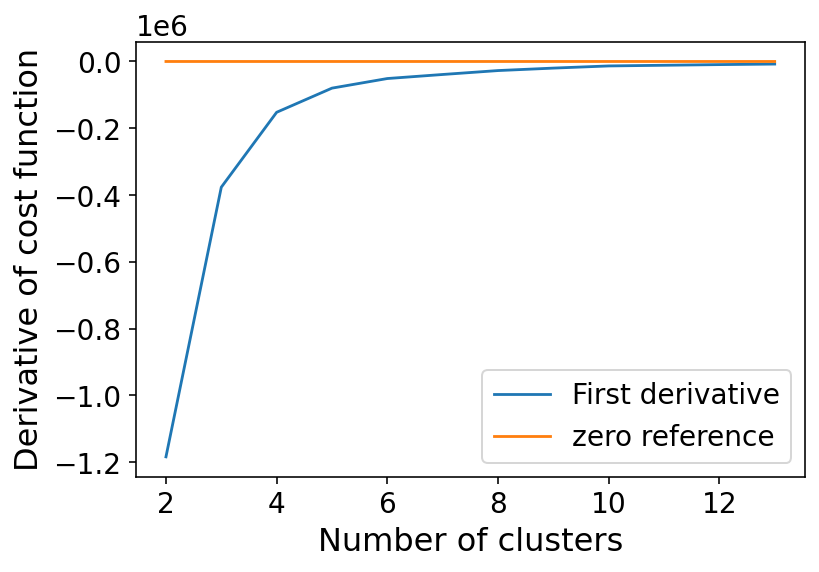

In [87]:
plt.plot([i+2 for i in range(12)], deriv1, label = "First derivative")
plt.plot([2,13], [2,0], label="zero reference")
plt.xlabel("Number of clusters")
plt.ylabel("Derivative of cost function")
plt.legend()
plt.show()

So the elbow of the previous curve is around 4 or 5 clusters. The difference between the derivative value and zero becomes small, which can be interpreted as falling below a certain threshold.

In [88]:
K = 4
kmeans = KMeans(n_clusters=K, random_state=0, algorithm="full").fit(ndata)

In [89]:
aux_means1 = []
aux_stdevs1 = []
aux_means2 = []
aux_stdevs2 = []
aux_means3 = []
aux_stdevs3 = []
aux_means4 = []
aux_stdevs4 = []

for i in range(len(means)):

    if kmeans.labels_[i] == 0:
        aux_means1.append(means[i]) #, stdevs[i], color="salmon", s=size)
        aux_stdevs1.append(stdevs[i]) #, stdevs[i], color="salmon", s=size)

    elif kmeans.labels_[i] == 1:
#         ax2.scatter(means[i], stdevs[i], color="deeppink", s=size)
        aux_means2.append(means[i]) #, stdevs[i], color="salmon", s=size)
        aux_stdevs2.append(stdevs[i]) #, stdevs[i], color="salmon", s=size)

    elif kmeans.labels_[i] == 2:
#         ax3.scatter(means[i], stdevs[i], color="dimgrey", s=size)
        aux_means3.append(means[i]) #, stdevs[i], color="salmon", s=size)
        aux_stdevs3.append(stdevs[i]) #, stdevs[i], color="salmon", s=size)
        
    elif kmeans.labels_[i] == 3:
        aux_means4.append(means[i]) #, stdevs[i], color="salmon", s=size)
        aux_stdevs4.append(stdevs[i]) #, stdevs[i], color="salmon", s=size)
        
    else:
        print("Something is worng in iteration: ",i)

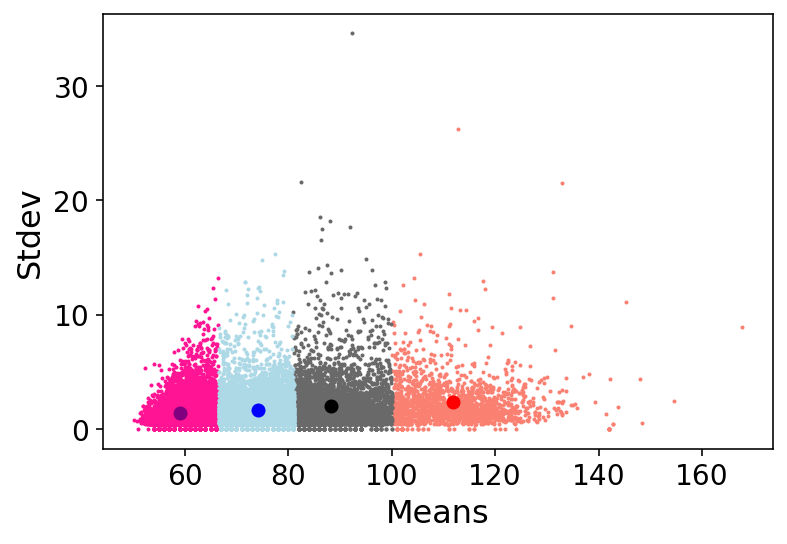

In [90]:
plt.scatter(aux_means1, aux_stdevs1, color="salmon", s=size)
plt.scatter(aux_means2, aux_stdevs2, color="deeppink", s=size)
plt.scatter(aux_means3, aux_stdevs3, color="dimgrey", s=size)
plt.scatter(aux_means4, aux_stdevs4, color="lightblue", s=size)

plt.scatter(kmeans.cluster_centers_[0,0], kmeans.cluster_centers_[0,1], c="r")
plt.scatter(kmeans.cluster_centers_[1,0], kmeans.cluster_centers_[1,1], c="purple")
plt.scatter(kmeans.cluster_centers_[2,0], kmeans.cluster_centers_[2,1], c="k")
plt.scatter(kmeans.cluster_centers_[3,0], kmeans.cluster_centers_[3,1], c="b")
plt.xlabel('Means')
plt.ylabel("Stdev")
plt.show()

In [91]:
K = 5
kmeans = KMeans(n_clusters=K, random_state=0, algorithm="full").fit(ndata)

In [92]:
aux_means1 = []
aux_stdevs1 = []
aux_means2 = []
aux_stdevs2 = []
aux_means3 = []
aux_stdevs3 = []
aux_means4 = []
aux_stdevs4 = []
aux_means5 = []
aux_stdevs5 = []

for i in range(len(means)):

    if kmeans.labels_[i] == 0:
        aux_means1.append(means[i]) #, stdevs[i], color="salmon", s=size)
        aux_stdevs1.append(stdevs[i]) #, stdevs[i], color="salmon", s=size)

    elif kmeans.labels_[i] == 1:
#         ax2.scatter(means[i], stdevs[i], color="deeppink", s=size)
        aux_means2.append(means[i]) #, stdevs[i], color="salmon", s=size)
        aux_stdevs2.append(stdevs[i]) #, stdevs[i], color="salmon", s=size)

    elif kmeans.labels_[i] == 2:
#         ax3.scatter(means[i], stdevs[i], color="dimgrey", s=size)
        aux_means3.append(means[i]) #, stdevs[i], color="salmon", s=size)
        aux_stdevs3.append(stdevs[i]) #, stdevs[i], color="salmon", s=size)
        
    elif kmeans.labels_[i] == 3:
        aux_means4.append(means[i]) #, stdevs[i], color="salmon", s=size)
        aux_stdevs4.append(stdevs[i]) #, stdevs[i], color="salmon", s=size)
        
    elif kmeans.labels_[i] == 4:
        aux_means5.append(means[i]) #, stdevs[i], color="salmon", s=size)
        aux_stdevs5.append(stdevs[i]) #, stdevs[i], color="salmon", s=size)
        
    else:
        print("Something is worng in iteration: ",i)

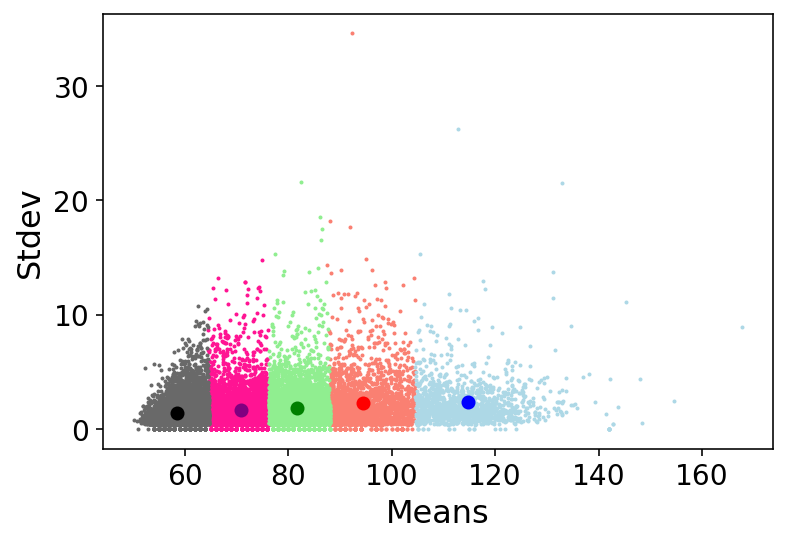

In [93]:
plt.scatter(aux_means1, aux_stdevs1, color="salmon", s=size)
plt.scatter(aux_means2, aux_stdevs2, color="deeppink", s=size)
plt.scatter(aux_means3, aux_stdevs3, color="dimgrey", s=size)
plt.scatter(aux_means4, aux_stdevs4, color="lightblue", s=size)
plt.scatter(aux_means5, aux_stdevs5, color="lightgreen", s=size)

plt.scatter(kmeans.cluster_centers_[0,0], kmeans.cluster_centers_[0,1], c="r")
plt.scatter(kmeans.cluster_centers_[1,0], kmeans.cluster_centers_[1,1], c="purple")
plt.scatter(kmeans.cluster_centers_[2,0], kmeans.cluster_centers_[2,1], c="k")
plt.scatter(kmeans.cluster_centers_[3,0], kmeans.cluster_centers_[3,1], c="b")
plt.scatter(kmeans.cluster_centers_[4,0], kmeans.cluster_centers_[4,1], c="green")
plt.xlabel('Means')
plt.ylabel("Stdev")
plt.show()

In [94]:
# Labeling the data based on the time of day
def activity_label_per_day(vecs_secs):
    activity_labels = []#np.zeros(len(vecs_secs))

    for i in range(len(vecs_secs)): # for every second in the day
        mean_time_5s_int = round(np.mean(vecs_secs[i]))
        
        if mean_time_5s_int >=86400: # The index corresponds to the next day
            mean_time_5s_int = mean_time_5s_int - 86400

        if 0 <= mean_time_5s_int and mean_time_5s_int < 21600: # 60*60*6 between midnight and 6 am
            activity_labels.append(0) # "sleep_0-6"
        elif 21600 <= mean_time_5s_int and mean_time_5s_int <= 43200: # 60*60*6 between midnight and 6 am
            activity_labels.append(1) # "morning_6-12"
        elif 43200 <= mean_time_5s_int and mean_time_5s_int < 50400: 
            activity_labels.append(2) # "eating_12-2pm"
        elif 50400 <= mean_time_5s_int and mean_time_5s_int < 68400:
            activity_labels.append(3) # "afternoon_2-7pm"        
        elif 68400 <= mean_time_5s_int and mean_time_5s_int < 75600:
            activity_labels.append(4) # "possibly_dancing_7-9pm"        
        elif 75600 <= mean_time_5s_int and mean_time_5s_int < 86400:
            activity_labels.append(5) # "night_9-12pm"
        else:
            print("There is something wrong with index: ",i)
            
    return activity_labels

In [95]:
activity_labels = activity_label_per_day(all_vecs_secs)

In [96]:
# Obtain the mean of the labeled activity clusters
values_c0_means = []
values_c0_stdevs = []
values_c1_means = []
values_c1_stdevs = []
values_c2_means = []
values_c2_stdevs = []
values_c3_means = []
values_c3_stdevs = []
values_c4_means = []
values_c4_stdevs = []
values_c5_means = []
values_c5_stdevs = []

for i in range(len(means)):
    if activity_labels[i] == 0:
        values_c0_means.append(means[i])
        values_c0_stdevs.append(stdevs[i])
        
    elif activity_labels[i] == 1:
        values_c1_means.append(means[i])
        values_c1_stdevs.append(stdevs[i])
      
    elif activity_labels[i] == 2:
        values_c2_means.append(means[i])
        values_c2_stdevs.append(stdevs[i])
     
    elif activity_labels[i] == 3:
        values_c3_means.append(means[i])
        values_c3_stdevs.append(stdevs[i])
  
    elif activity_labels[i] == 4:
        values_c4_means.append(means[i])
        values_c4_stdevs.append(stdevs[i])

    elif activity_labels[i] == 5:
        values_c5_means.append(means[i])
        values_c5_stdevs.append(stdevs[i])

    else:
        print("Something is wrong in iteration: ",i)

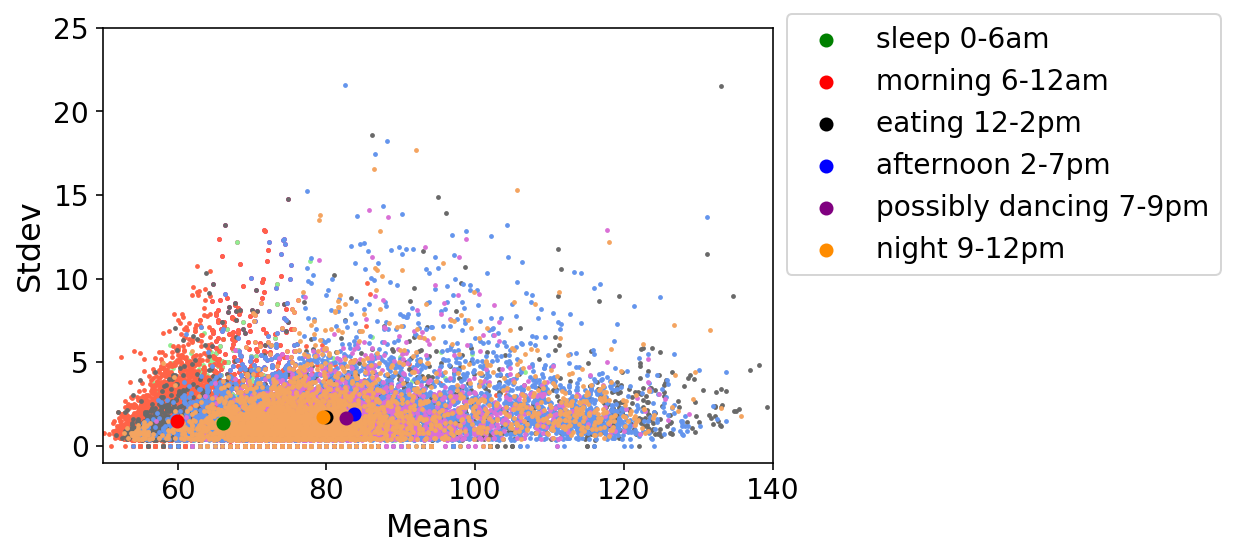

In [97]:
size = 2
 
plt.scatter(aux_means2, aux_stdevs2, color="deeppink", s=size)

plt.scatter(values_c0_means, values_c0_stdevs, c="lightgreen", s=2)
plt.scatter(values_c1_means, values_c1_stdevs, c="tomato", s=2)
plt.scatter(values_c2_means, values_c2_stdevs, c="dimgrey", s=2)
plt.scatter(values_c3_means, values_c3_stdevs, c="cornflowerblue", s=2)
plt.scatter(values_c4_means, values_c4_stdevs, c="orchid", s=2)
plt.scatter(values_c5_means, values_c5_stdevs, c="sandybrown", s=2)

plt.scatter(np.mean(values_c0_means), np.mean(values_c0_stdevs), c="green", label = "sleep 0-6am")
plt.scatter(np.mean(values_c1_means), np.mean(values_c1_stdevs), c="r", label = "morning 6-12am")
plt.scatter(np.mean(values_c2_means), np.mean(values_c2_stdevs), c="k", label = "eating 12-2pm")
plt.scatter(np.mean(values_c3_means), np.mean(values_c3_stdevs), c="b", label="afternoon 2-7pm")
plt.scatter(np.mean(values_c4_means), np.mean(values_c4_stdevs), c="purple", label = "possibly dancing 7-9pm")
plt.scatter(np.mean(values_c5_means), np.mean(values_c5_stdevs), c="darkorange", label = "night 9-12pm")
plt.xlabel('Means')
plt.ylabel("Stdev")
plt.xlim([50, 140])
plt.ylim([-1, 25])
plt.legend(bbox_to_anchor=(1,0.4))
plt.show()

Text(0, 0.5, 'Stdev')

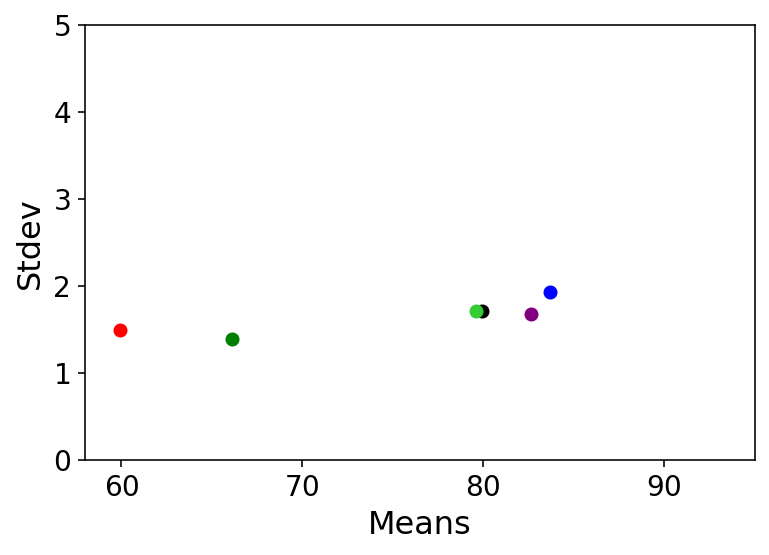

In [98]:
plt.scatter(np.mean(values_c0_means), np.mean(values_c0_stdevs), c="green")
plt.scatter(np.mean(values_c1_means), np.mean(values_c1_stdevs), c="r")
plt.scatter(np.mean(values_c2_means), np.mean(values_c2_stdevs), c="k")
plt.scatter(np.mean(values_c3_means), np.mean(values_c3_stdevs), c="b")
plt.scatter(np.mean(values_c4_means), np.mean(values_c4_stdevs), c="purple")
plt.scatter(np.mean(values_c5_means), np.mean(values_c5_stdevs), c="limegreen")
plt.xlim(58,95)
plt.ylim(0,5)
plt.xlabel('Means')
plt.ylabel("Stdev")

# IDEA
Does the optimal number of clusters change if we modify the time window considered to 1 min?

# ARGUE. Why the labels do not work in this case. Different physical activity data under the same label. Side by side comparison of 5 or 6 clusters and this labeling.


# ARGUE The optimal number of clusters related with some physiological value.
Amount of exercise.
- Red one is when sleeping.
- Next one some activity when awake that is not vigorous, like taking a class, being in a desk.
- Next one could be like walking or such
- Next one riding a bike, dancing?

I am curious for the amount of stdev in some of the recordings, though.

Maybe the stadard deviation associated to each data cluster can be associated too with the amounbt of heart rate variability or healthiness of a person? I do not know, some of the dots with high standard deviation must be due to noise or artifacts. But there must be some intrinsic variability of the heart which must be related to health.

color="green", s=size, label="sleep_0-6"
color="red", s=size, label = "morning_6-12"
color="black", s=size, label = "eating_12-2pm"
color="blue", s=size, label = "afternoon_2-7pm"
color="purple", s=size, label = "possibly_dancing_7-9pm"
color="limegreen", s=size, label = "night_9-12pm"

# IDEA
What if we now use gaussian mixtures to cluster?

You have several recordings,so you could divide it in the training and test data. Wait, no. Divide the data from the same recording? Use recordings from multiple days? Well, everything is just one big continuos recording. But yes, you could use complete days as training or test.

Use covariance_type='full'

# IDEA
Use principal components analysis to cluster.

# THE CODE SHOULD RUN UNTIL HERE.

In [99]:
training = Peaks[:5000,:]
# means[i], stdevs
classification = gmix.fit(training).predict(training) +1 # You are assinging to each component one class from 1 to 10

NameError: name 'Peaks' is not defined

In [ ]:
# Code from homework assignment HW4
gmix = mixture.GaussianMixture(n_components=10, covariance_type='full')
gmix.fit(Peaks)
np.shape(Peaks)

training = Peaks[:5000,:]
classification = gmix.fit(training).predict(training) +1 # You are assinging to each component one class from 1 to 10

In [ ]:
# Code from HW4 part a
# Plot with cluster labels legend
PP = pd.DataFrame(np.array(training))
PP["Cluster"] = classification.tolist()
g = sns.PairGrid(PP, hue = "Cluster")
g = g.map_lower(plt.hexbin, gridsize=50, mincnt=1, cmap='jet_r',bins='log')

for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)
g.add_legend()
plt.show()



In [ ]:
# Code from HW4 part b
training = Peaks[:5000,:]
test = Peaks[5000:10000,:]

ks = [i+8 for i in range(13)]
scores = np.zeros(len(ks))
classifications = []

for i in range(len(ks)):
    gmix = mixture.GaussianMixture(n_components=ks[i], covariance_type='full')
    classification = gmix.fit(training).predict(test) +1 # You are assinging to each component one class
    classifications.append(classification)
    scores[i] = gmix.fit(training).score(test) # Likelihood of the test data
    
# K value that maximizes the likelihood
best_k_value = np.argmax(scores)+8
print("Number of clusters (K) that maximizes the likelihood: ",best_k_value)

In [ ]:


plt.plot(ks, scores)
plt.xlabel("K")
plt.ylabel("Likelihood")
plt.title("One trial")
plt.show()



In [ ]:


# Plot with cluster labels legend
PP = pd.DataFrame(np.array(test))
PP["Cluster"] = classifications[best_k_value-8].tolist()
g = sns.PairGrid(PP, hue = "Cluster")
g = g.map_lower(plt.hexbin, gridsize=50, mincnt=1, cmap='jet',bins='log')

for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)
g.add_legend()
plt.show()



In [ ]:
# Suffling the data and obtain an average likelihood
ks = [i+8 for i in range(13)]
scores = np.zeros(len(ks))
repetitions = 20

for i in range(len(ks)):
    for same_k_i in range(repetitions):
        # In each iteration, data will be shuffled again
        shuffled_data = shuffle(Peaks)
        training = shuffled_data[:5000,:]
        test = shuffled_data[5000:10000,:]

        gmix = mixture.GaussianMixture(n_components=ks[i], covariance_type='full')
        scores[i] += gmix.fit(training).score(test) # Likelihood of the test data

scores = scores/repetitions

best_averaged_k_value = np.round(np.argmax(scores)+8)
print("K value that maximizes the likelihood:",best_averaged_k_value) 

In [ ]:
plt.plot(ks, scores)
plt.xlabel("K")
plt.ylabel("Likelihood")
plt.title("Average trend")
plt.show()

# Review and modify based on Della's comments in this NB


Comments on HW5 (PCA):
Q1. a. (-4) sklearn PCA input data X should be of shape (n_samples, n_features). pca.explained_variance_ is the eigenvalue, not pca.singular_values_. You did it right in b and c, I am confused why you did (a) differently :0 Q2. e. (-3) For all channel data, you shouldn't truncate eigenvectors_160 while computing projections. This is why you are computing total_var_backprojection_160 wrong Q3. a. (-1) The assumed noise would draw the projected points closer to their mean b. (-5) You result didn't look right. While estimating new psi, you need to use np.diag(np.diag()) to get the diagonal of the matrix. Further, if you run the FA multiple times with different random psi initializations, you will find FA gives multiple local optimums. 

Della's comments for further reference

Comments on HW4:
- Q1. (-3) Recall that you are using argmax(x[5:25]), you need to add 5 back to the argmax index when extracted peak values
- Q4. (-5) You had the same mistake as Q1 so the peaks you were using are wrong.
- Q5. b. (-2) Distance should be computed as the euclidean distance rather than L1 norm c. (-5) The datapoints at the boundary of clusters should have minimum euclidean distance to all 2/3/4 centers 


Comments about HW3:

Q1. Actually I would prefer to call the 'lambda' you computed in each trial as firing rate since you haven't done any averaging across trials yet. (-1) To avoid error of log(lambda=0), replace lambda with small value like 1e-5. Setting 'log_term = -230*x_d' doesn't seem to be a good way to go. Q2. Nice figures and labeling. Don't literally need to include movement data. 2b, (-3) Lack of description and explaination on your results. Q3. (-5) Since you are randomly droping neurons, you need to randomly drop them by 20 times. Then estimate the mean and variations of decoding accuracy. You'll find your curve (decoding accuracy vs. number of dropped neurons) much smoother. 
